# Pipeline Describe
- Download Data
- Load Data
- Analyze trend and cycle
- Transform for stationarity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, arma_order_select_ic
import itertools
import warnings


#Own packages
import download
import descriptive
# import models
# import model_wrapper

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [20]:
params = {
    'outcome_col': 'iva_neto_(mdp)_r',
    'nombre_legible': 'IVA neto'}

## Download Data

In [4]:
# download.get_files(inpc=True, fiscal_current=True, fiscal_hist=True)

## Load Data

In [5]:
fiscal_income_df = download.load_fiscal_income()
fiscal_income_df = fiscal_income_df.asfreq(freq='MS')

## Describing Data

In [6]:
fiscal_income_df.columns

Index(['ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ingresos_no_tributarios_neto_(mdp)',
       'ingresos_gobierno_federal_neto_(mdp)',
       'ingresos_tributarios_neto_(mdp)', 'isr_neto_(mdp)', 'inpc',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ingresos_no_tributarios_neto_(mdp)_r',
       'ingresos_gobierno_federal_neto_(mdp)_r',
       'ingresos_tributarios_neto_(mdp)_r', 'isr_neto_(mdp)_r'],
      dtype='object')

In [7]:
display(fiscal_income_df.columns)
display(fiscal_income_df.shape)
display(fiscal_income_df.isnull().any())
display(fiscal_income_df.head())
display(fiscal_income_df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

Index(['ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ingresos_no_tributarios_neto_(mdp)',
       'ingresos_gobierno_federal_neto_(mdp)',
       'ingresos_tributarios_neto_(mdp)', 'isr_neto_(mdp)', 'inpc',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ingresos_no_tributarios_neto_(mdp)_r',
       'ingresos_gobierno_federal_neto_(mdp)_r',
       'ingresos_tributarios_neto_(mdp)_r', 'isr_neto_(mdp)_r'],
      dtype='object')

(352, 15)

ingresos_sector_publico_neto_(mdp)        False
iva_neto_(mdp)                            False
ieps_neto_(mdp)                           False
ingresos_no_tributarios_neto_(mdp)        False
ingresos_gobierno_federal_neto_(mdp)      False
ingresos_tributarios_neto_(mdp)           False
isr_neto_(mdp)                            False
inpc                                      False
ingresos_sector_publico_neto_(mdp)_r      False
iva_neto_(mdp)_r                          False
ieps_neto_(mdp)_r                         False
ingresos_no_tributarios_neto_(mdp)_r      False
ingresos_gobierno_federal_neto_(mdp)_r    False
ingresos_tributarios_neto_(mdp)_r         False
isr_neto_(mdp)_r                          False
dtype: bool

,ingresos_sector_publico_neto_(mdp),iva_neto_(mdp),ieps_neto_(mdp),ingresos_no_tributarios_neto_(mdp),ingresos_gobierno_federal_neto_(mdp),ingresos_tributarios_neto_(mdp),isr_neto_(mdp),inpc,ingresos_sector_publico_neto_(mdp)_r,iva_neto_(mdp)_r,ieps_neto_(mdp)_r,ingresos_no_tributarios_neto_(mdp)_r,ingresos_gobierno_federal_neto_(mdp)_r,ingresos_tributarios_neto_(mdp)_r,isr_neto_(mdp)_r
fecha,,,,,,,,,,,,,,,
1990-01-01,15527.708,2092.649,1040.445,7923.974,10861.811,7603.734,3897.608,7.532511,206142.514209,27781.558374,13812.724209,105196.975812,144199.068427,100945.538398,51743.806138
1990-02-01,12748.535,1796.237,887.693,7192.572,8522.032,5555.963,2299.732,7.703079,165499.204974,23318.427995,11523.872018,93372.685388,110631.497718,72126.519585,29854.710181
1990-03-01,14284.656,2005.865,800.115,8635.537,8296.806,5649.119,2082.503,7.838879,182228.301621,25588.671665,10207.007964,110162.907745,105841.741394,72065.393876,26566.336971
1990-04-01,14074.744,2032.419,860.166,7489.060,9702.308,6585.684,3020.333,7.958183,176858.752248,25538.730110,10808.572112,94105.143732,121916.113487,82753.608516,37952.542920
1990-05-01,14048.018,2060.314,801.122,8258.059,8834.236,5789.959,2311.738,8.097060,173495.299043,25445.211812,9893.986537,101988.367022,109104.246353,71506.932021,28550.338960


,ingresos_sector_publico_neto_(mdp),iva_neto_(mdp),ieps_neto_(mdp),ingresos_no_tributarios_neto_(mdp),ingresos_gobierno_federal_neto_(mdp),ingresos_tributarios_neto_(mdp),isr_neto_(mdp),inpc,ingresos_sector_publico_neto_(mdp)_r,iva_neto_(mdp)_r,ieps_neto_(mdp)_r,ingresos_no_tributarios_neto_(mdp)_r,ingresos_gobierno_federal_neto_(mdp)_r,ingresos_tributarios_neto_(mdp)_r,isr_neto_(mdp)_r
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,178691.439147,28908.803784,6712.549968,93515.994462,129484.645680,85175.444710,44842.294945,52.803579,292837.663605,45626.125012,12048.116364,156646.270310,209609.152994,136191.393330,69119.548277
std,137825.704445,23164.948952,12215.370159,73426.901415,104122.125162,74267.992481,42370.611192,27.120953,105936.795480,19650.857184,14609.028105,66329.855729,84094.696869,59292.999224,37346.358084
min,12748.535000,1796.237000,-40485.066000,7192.572000,8296.806000,5555.963000,2082.503000,7.532511,154630.044206,17122.359274,-63305.085377,64676.456378,96808.355538,59090.085973,21746.830114
25%,56511.095500,7427.295000,1064.180500,30375.018250,38304.509250,23550.126000,10685.149500,29.938181,198415.482807,27162.026622,4684.218801,105026.403580,138780.616779,94918.181920,41745.163442
50%,148864.589500,23701.243000,3107.447085,84446.537000,107498.729500,63949.477500,29094.310500,55.275909,272973.683635,43790.888818,12052.564886,145417.723843,192267.773114,117403.923612,56024.107275
75%,284114.699750,44888.798612,9342.124000,145851.403550,203699.450025,110857.581500,65551.318535,75.419434,371163.274247,59329.852992,19410.040057,187916.032644,263215.017520,155157.104437,85508.693416
85%,327256.770435,56353.126597,15589.634648,167968.401140,246684.088785,171519.262550,89724.417936,84.115577,397596.259853,68020.232758,26201.933782,214009.346290,297016.046377,206246.463950,107862.223832
95%,425787.902600,74426.980305,32852.311435,194225.447650,315551.541575,246993.549360,129757.644630,94.104479,454263.196622,80099.462007,35998.523525,272534.255357,348244.365311,267693.106285,141227.744799
99%,514036.231670,83434.382496,38734.504564,331003.160186,388916.231332,288273.417547,173803.201991,99.821675,614273.820183,91476.172318,44440.138064,425604.616230,407483.862653,308726.897635,193856.549214


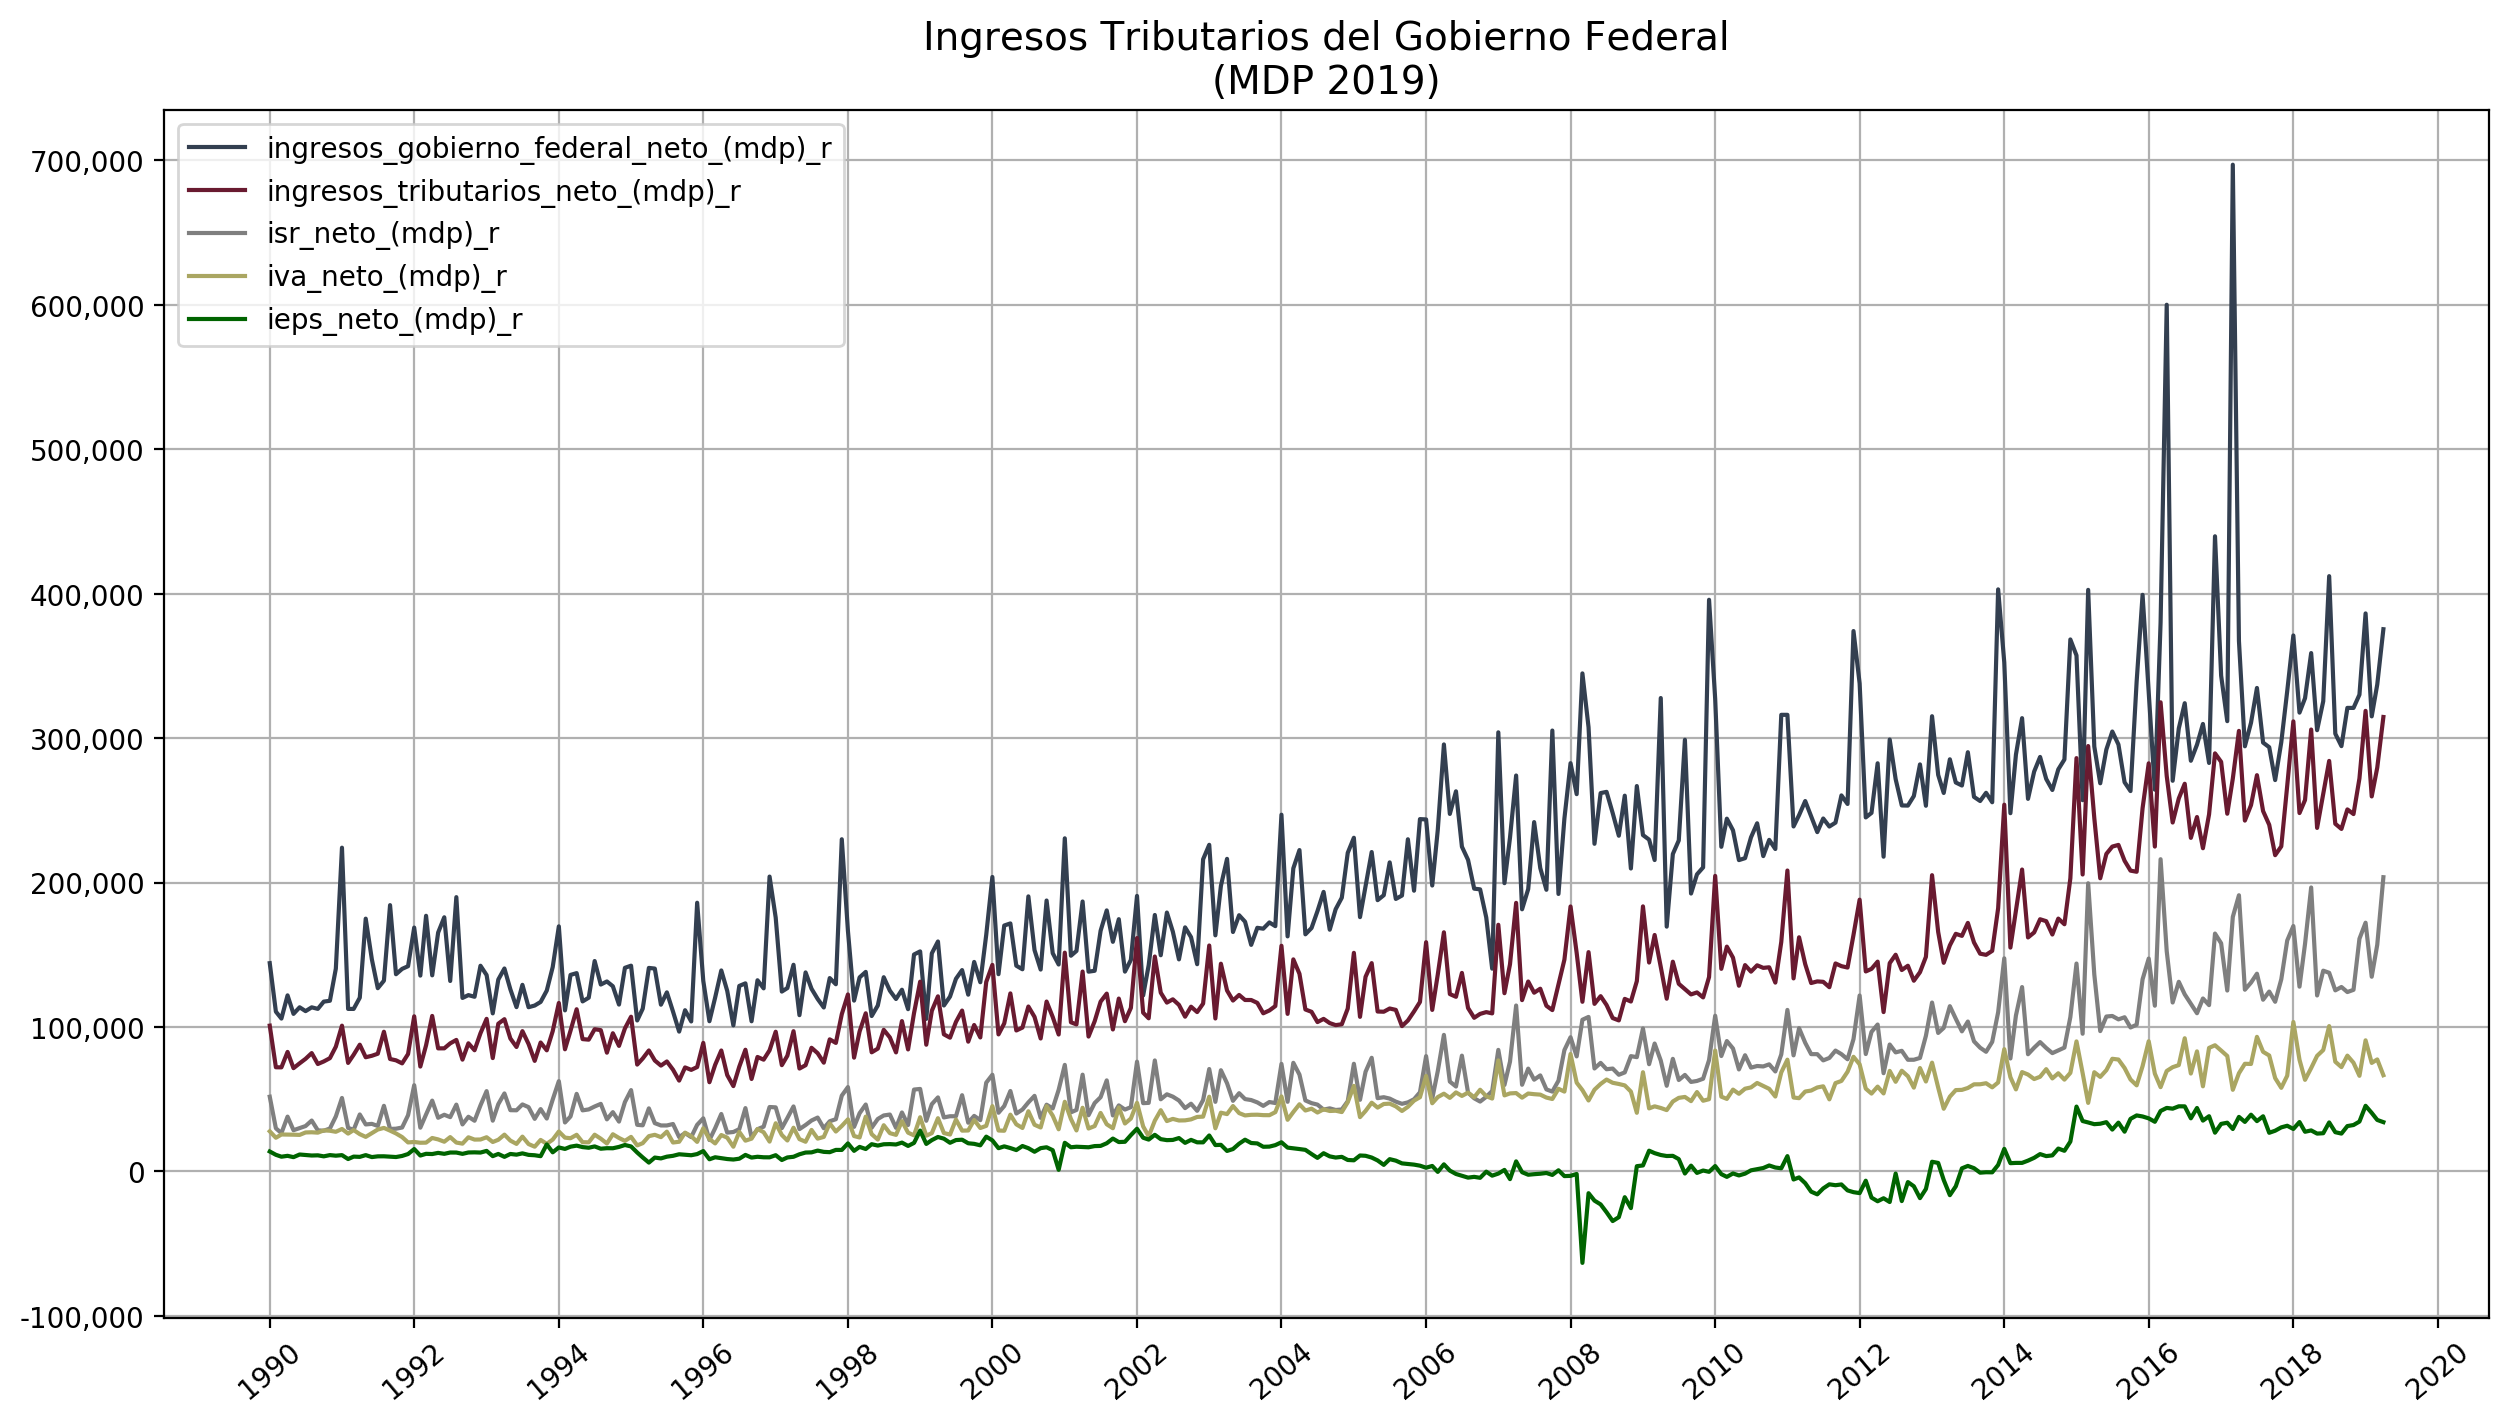

In [8]:
to_plot = ['ingresos_gobierno_federal_neto_(mdp)_r', 'ingresos_tributarios_neto_(mdp)_r', 'isr_neto_(mdp)_r',
           'iva_neto_(mdp)_r', 'ieps_neto_(mdp)_r']
descriptive.plot_series(fiscal_income_df, to_plot, 'Ingresos Tributarios del Gobierno Federal', 
                        '(MDP 2019)', ticks = 'yearly', ticks_freq=2)

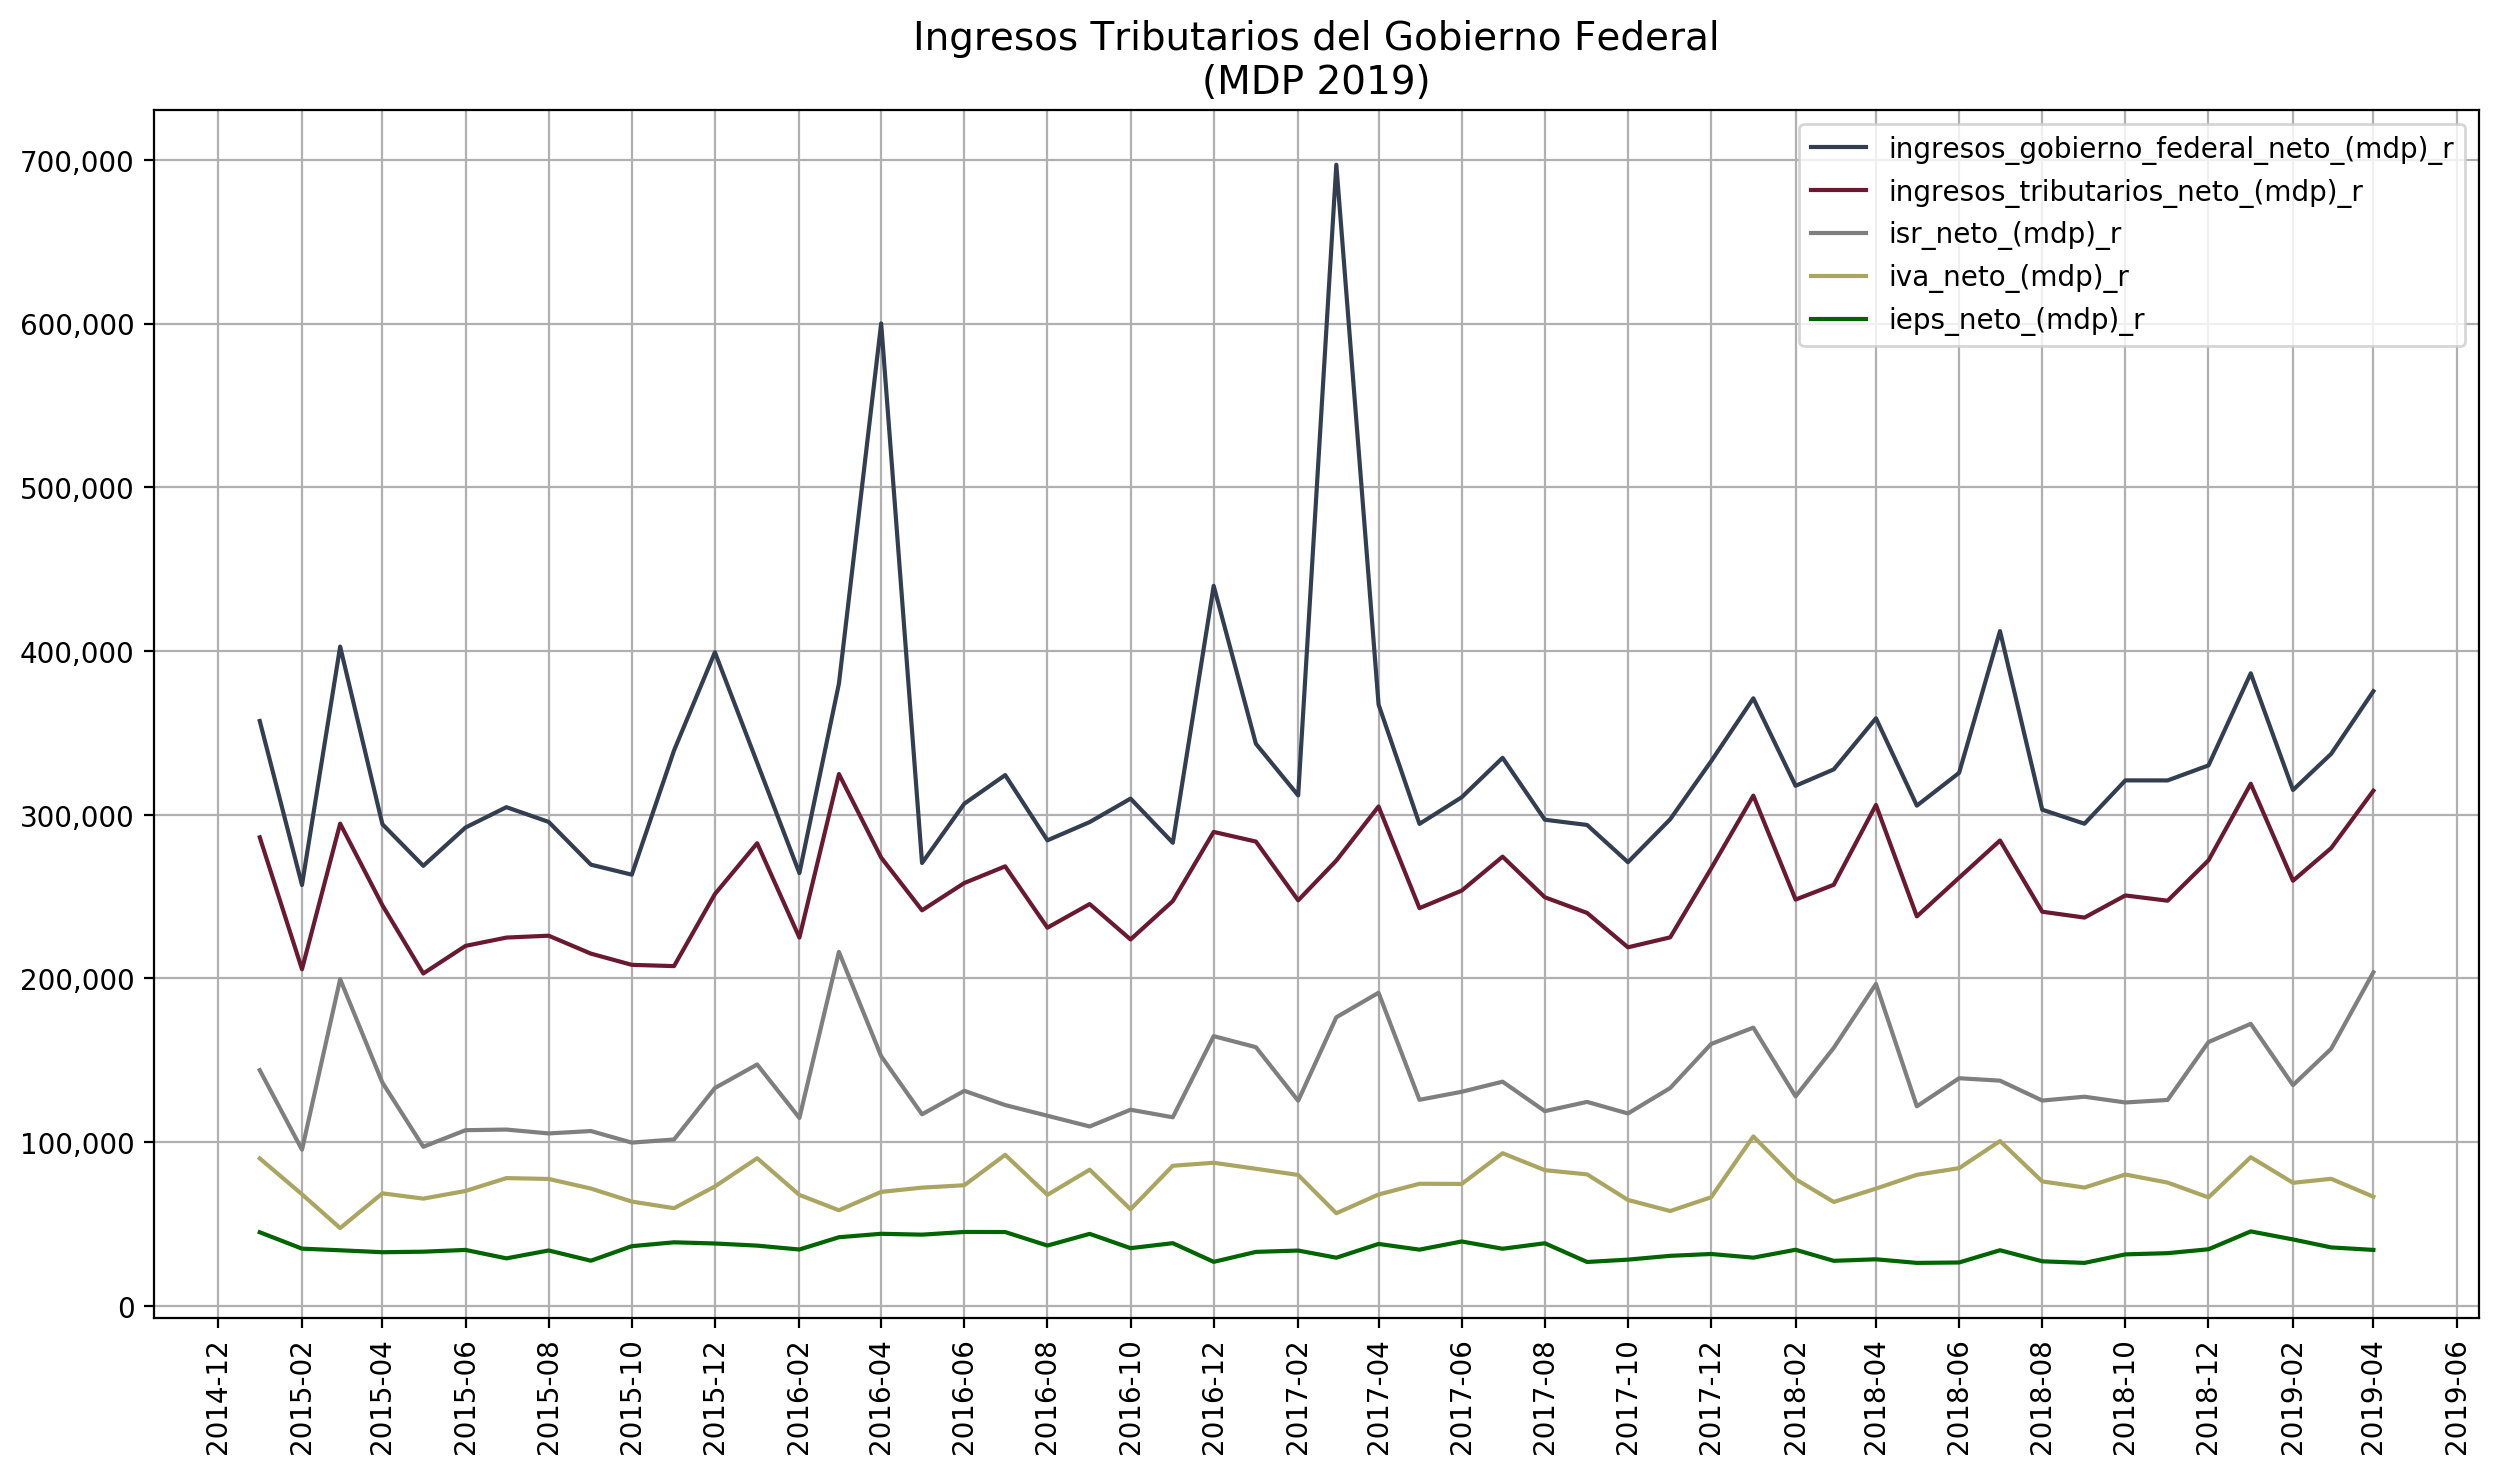

In [9]:
to_plot = ['ingresos_gobierno_federal_neto_(mdp)_r', 'ingresos_tributarios_neto_(mdp)_r', 'isr_neto_(mdp)_r',
           'iva_neto_(mdp)_r', 'ieps_neto_(mdp)_r']
descriptive.plot_series(fiscal_income_df, to_plot, 'Ingresos Tributarios del Gobierno Federal', 
                        '(MDP 2019)', ticks = 'monthly', ticks_freq=2, min_date='2015-01-01')

## Decomposition Naive

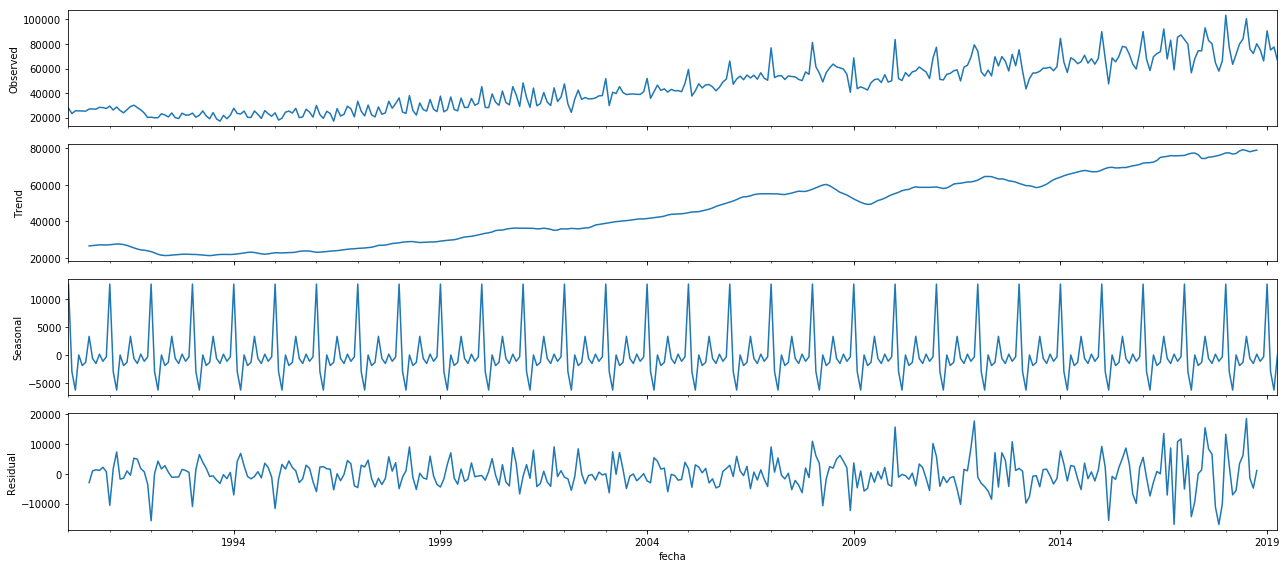

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(fiscal_income_df[params['outcome_col']], model='additive')
fig = decomposition.plot()
plt.show()

Se ve tendencia positiva en ingresos tributarios y estacionalidad. 

### Zoom a estacionalidad

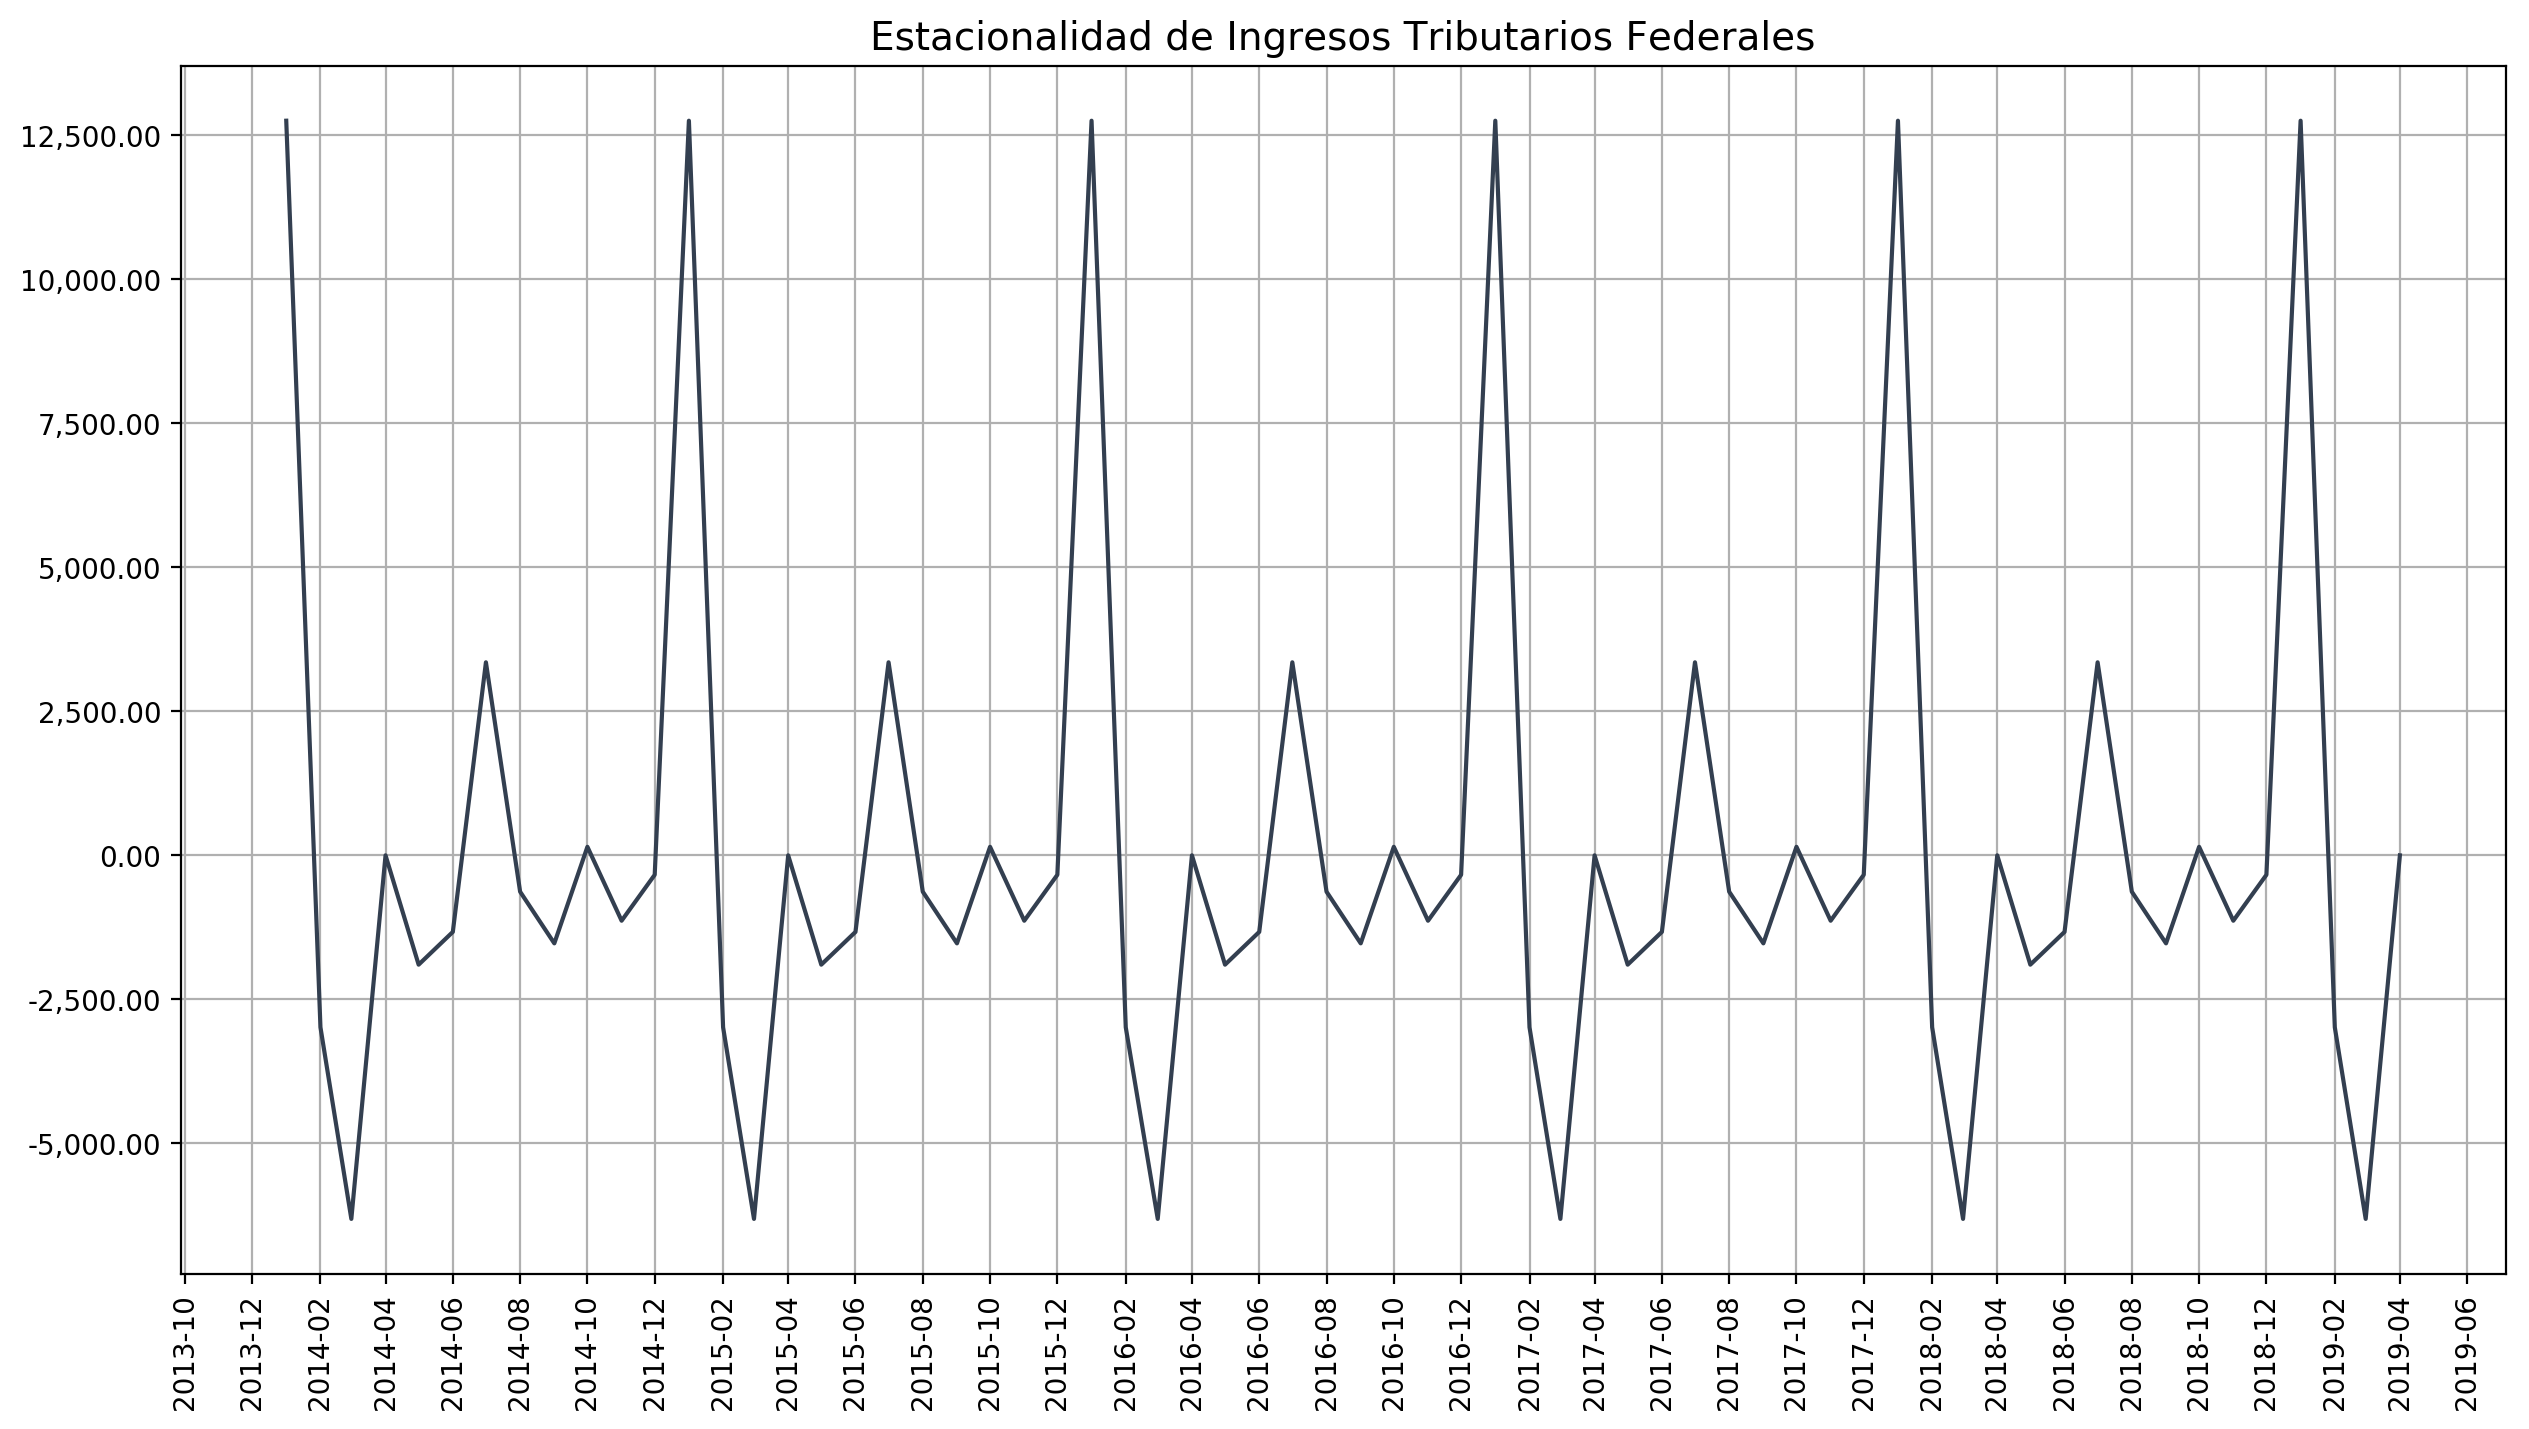

In [11]:
descriptive.plot_series(decomposition.seasonal, title='Estacionalidad de Ingresos Tributarios Federales',
                        figsize=(15, 8), legend=False, ticks = 'monthly',
                        ticks_freq= 2, min_date= '2014-01-01')

Se ve tendencia positiva de ingresos fiscales, así como fuerte componente estacional.Diciembre y Enero son los meses con mayores ingresos, Febrero siempre tiene una caida muy fuerte. Marzo es también de altos ingresos, y los demás meses se mantienen oscilando en niveles bajos y medios. 

## Hodrick Prescot

In [40]:
cycle, trend = sm.tsa.filters.hpfilter(fiscal_income_df[params['outcome_col']], 129600)
hp_decomp = fiscal_income_df[[params['outcome_col']]].copy()
hp_decomp["cycle"] = cycle
hp_decomp["trend"] = trend

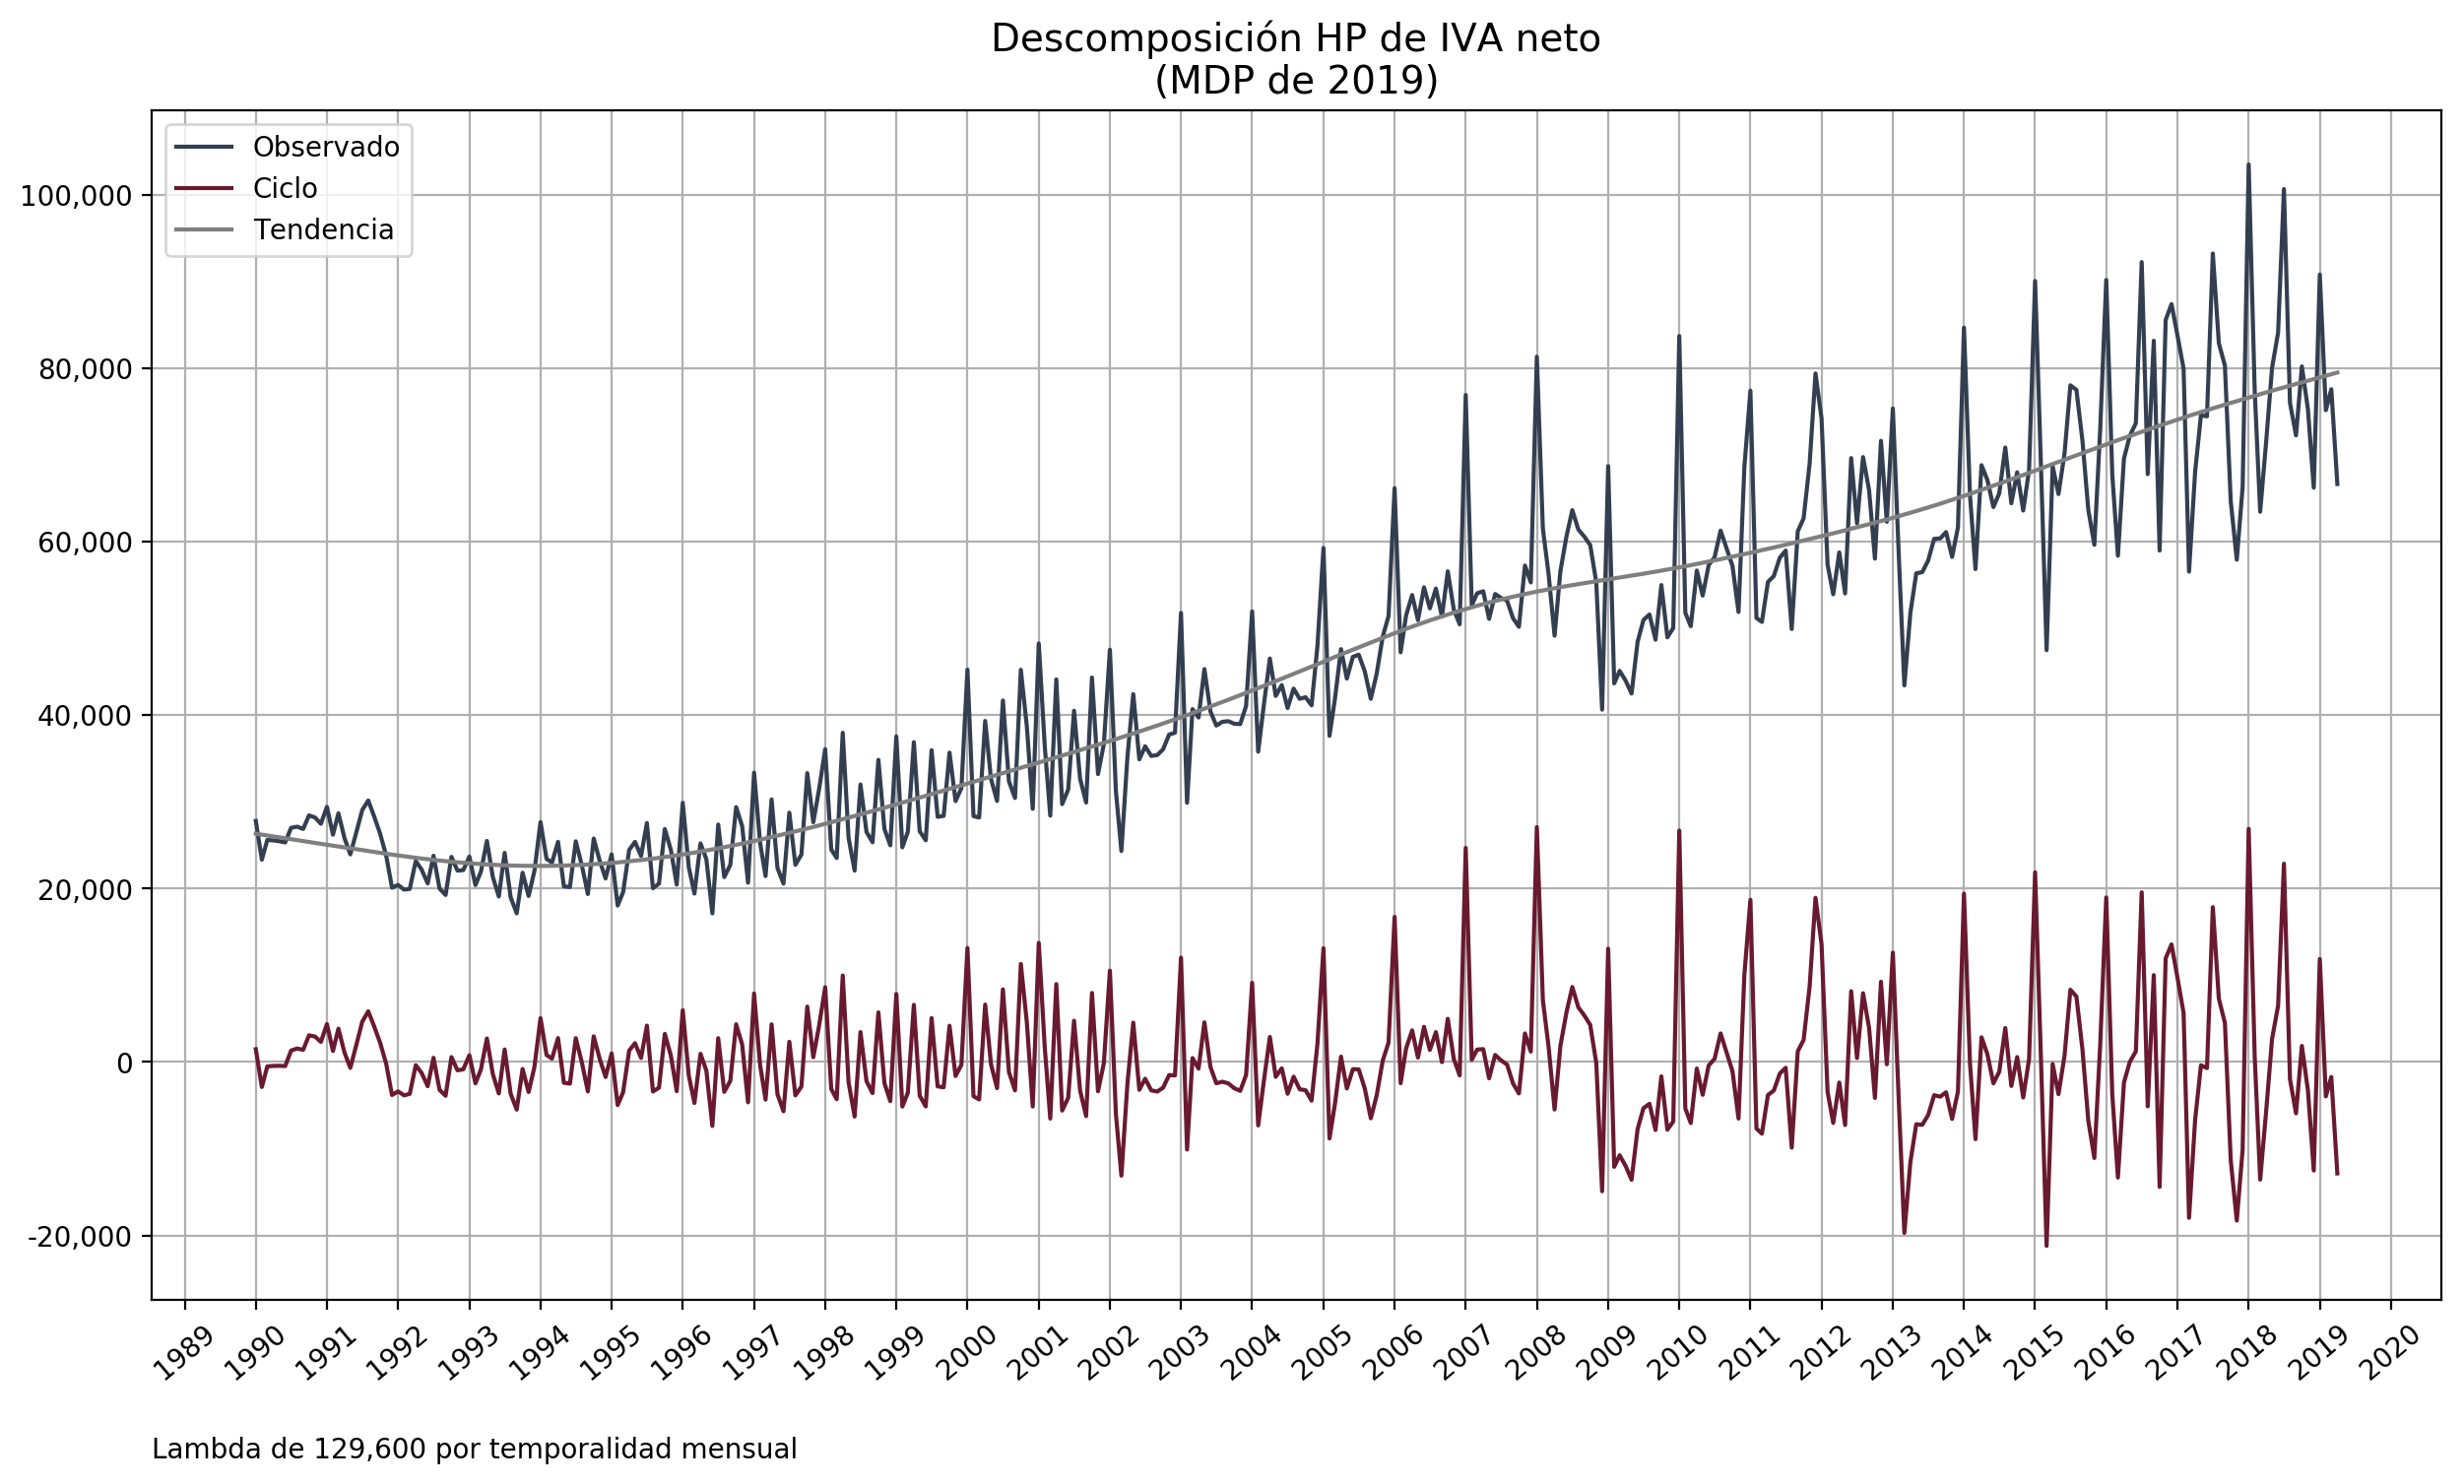

In [38]:
descriptive.plot_series(hp_decomp,
                        title='Descomposición HP de {}'.format(params['nombre_legible']),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

In [28]:
fiscal_income_df.columns

Index(['ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ingresos_no_tributarios_neto_(mdp)',
       'ingresos_gobierno_federal_neto_(mdp)',
       'ingresos_tributarios_neto_(mdp)', 'isr_neto_(mdp)', 'inpc',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ingresos_no_tributarios_neto_(mdp)_r',
       'ingresos_gobierno_federal_neto_(mdp)_r',
       'ingresos_tributarios_neto_(mdp)_r', 'isr_neto_(mdp)_r'],
      dtype='object')

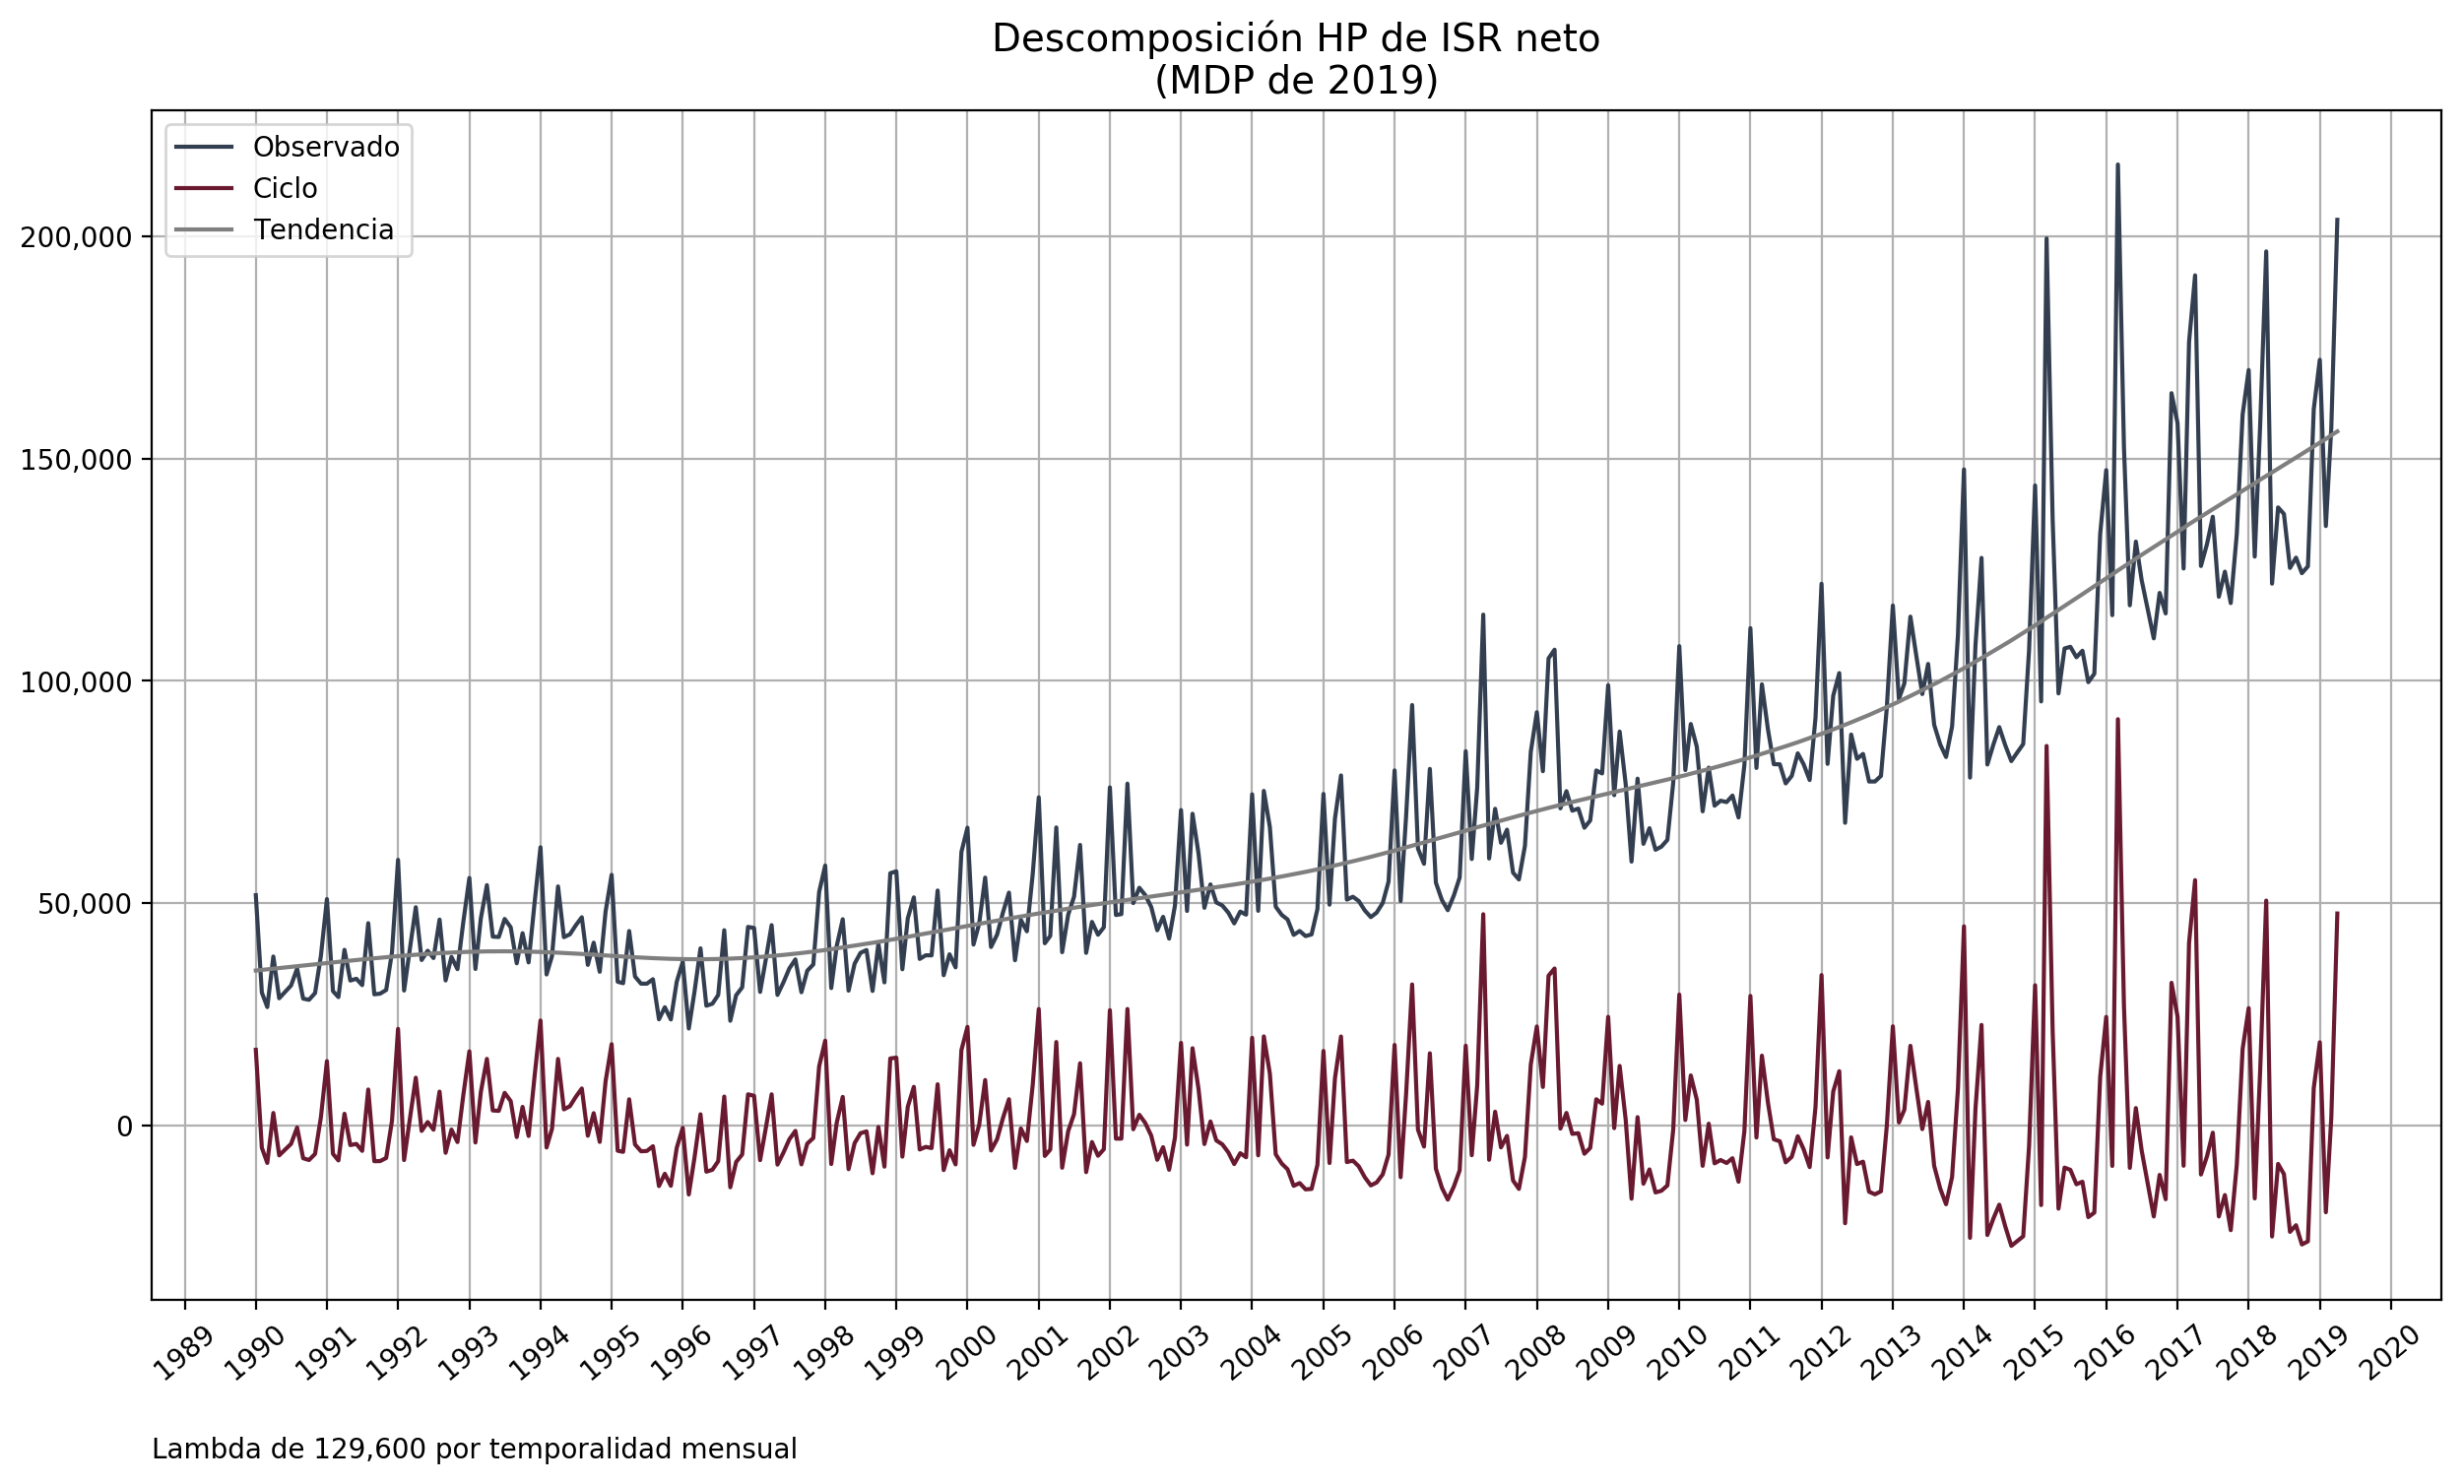

In [52]:
cycle_isr, trend_isr = sm.tsa.filters.hpfilter(fiscal_income_df['isr_neto_(mdp)_r'], 129600)
hp_decomp_isr = fiscal_income_df[['isr_neto_(mdp)_r']].copy()
hp_decomp_isr["cycle"] = cycle_isr
hp_decomp_isr["trend"] = trend_isr
descriptive.plot_series(hp_decomp_isr,
                        title='Descomposición HP de {}'.format('ISR neto'),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

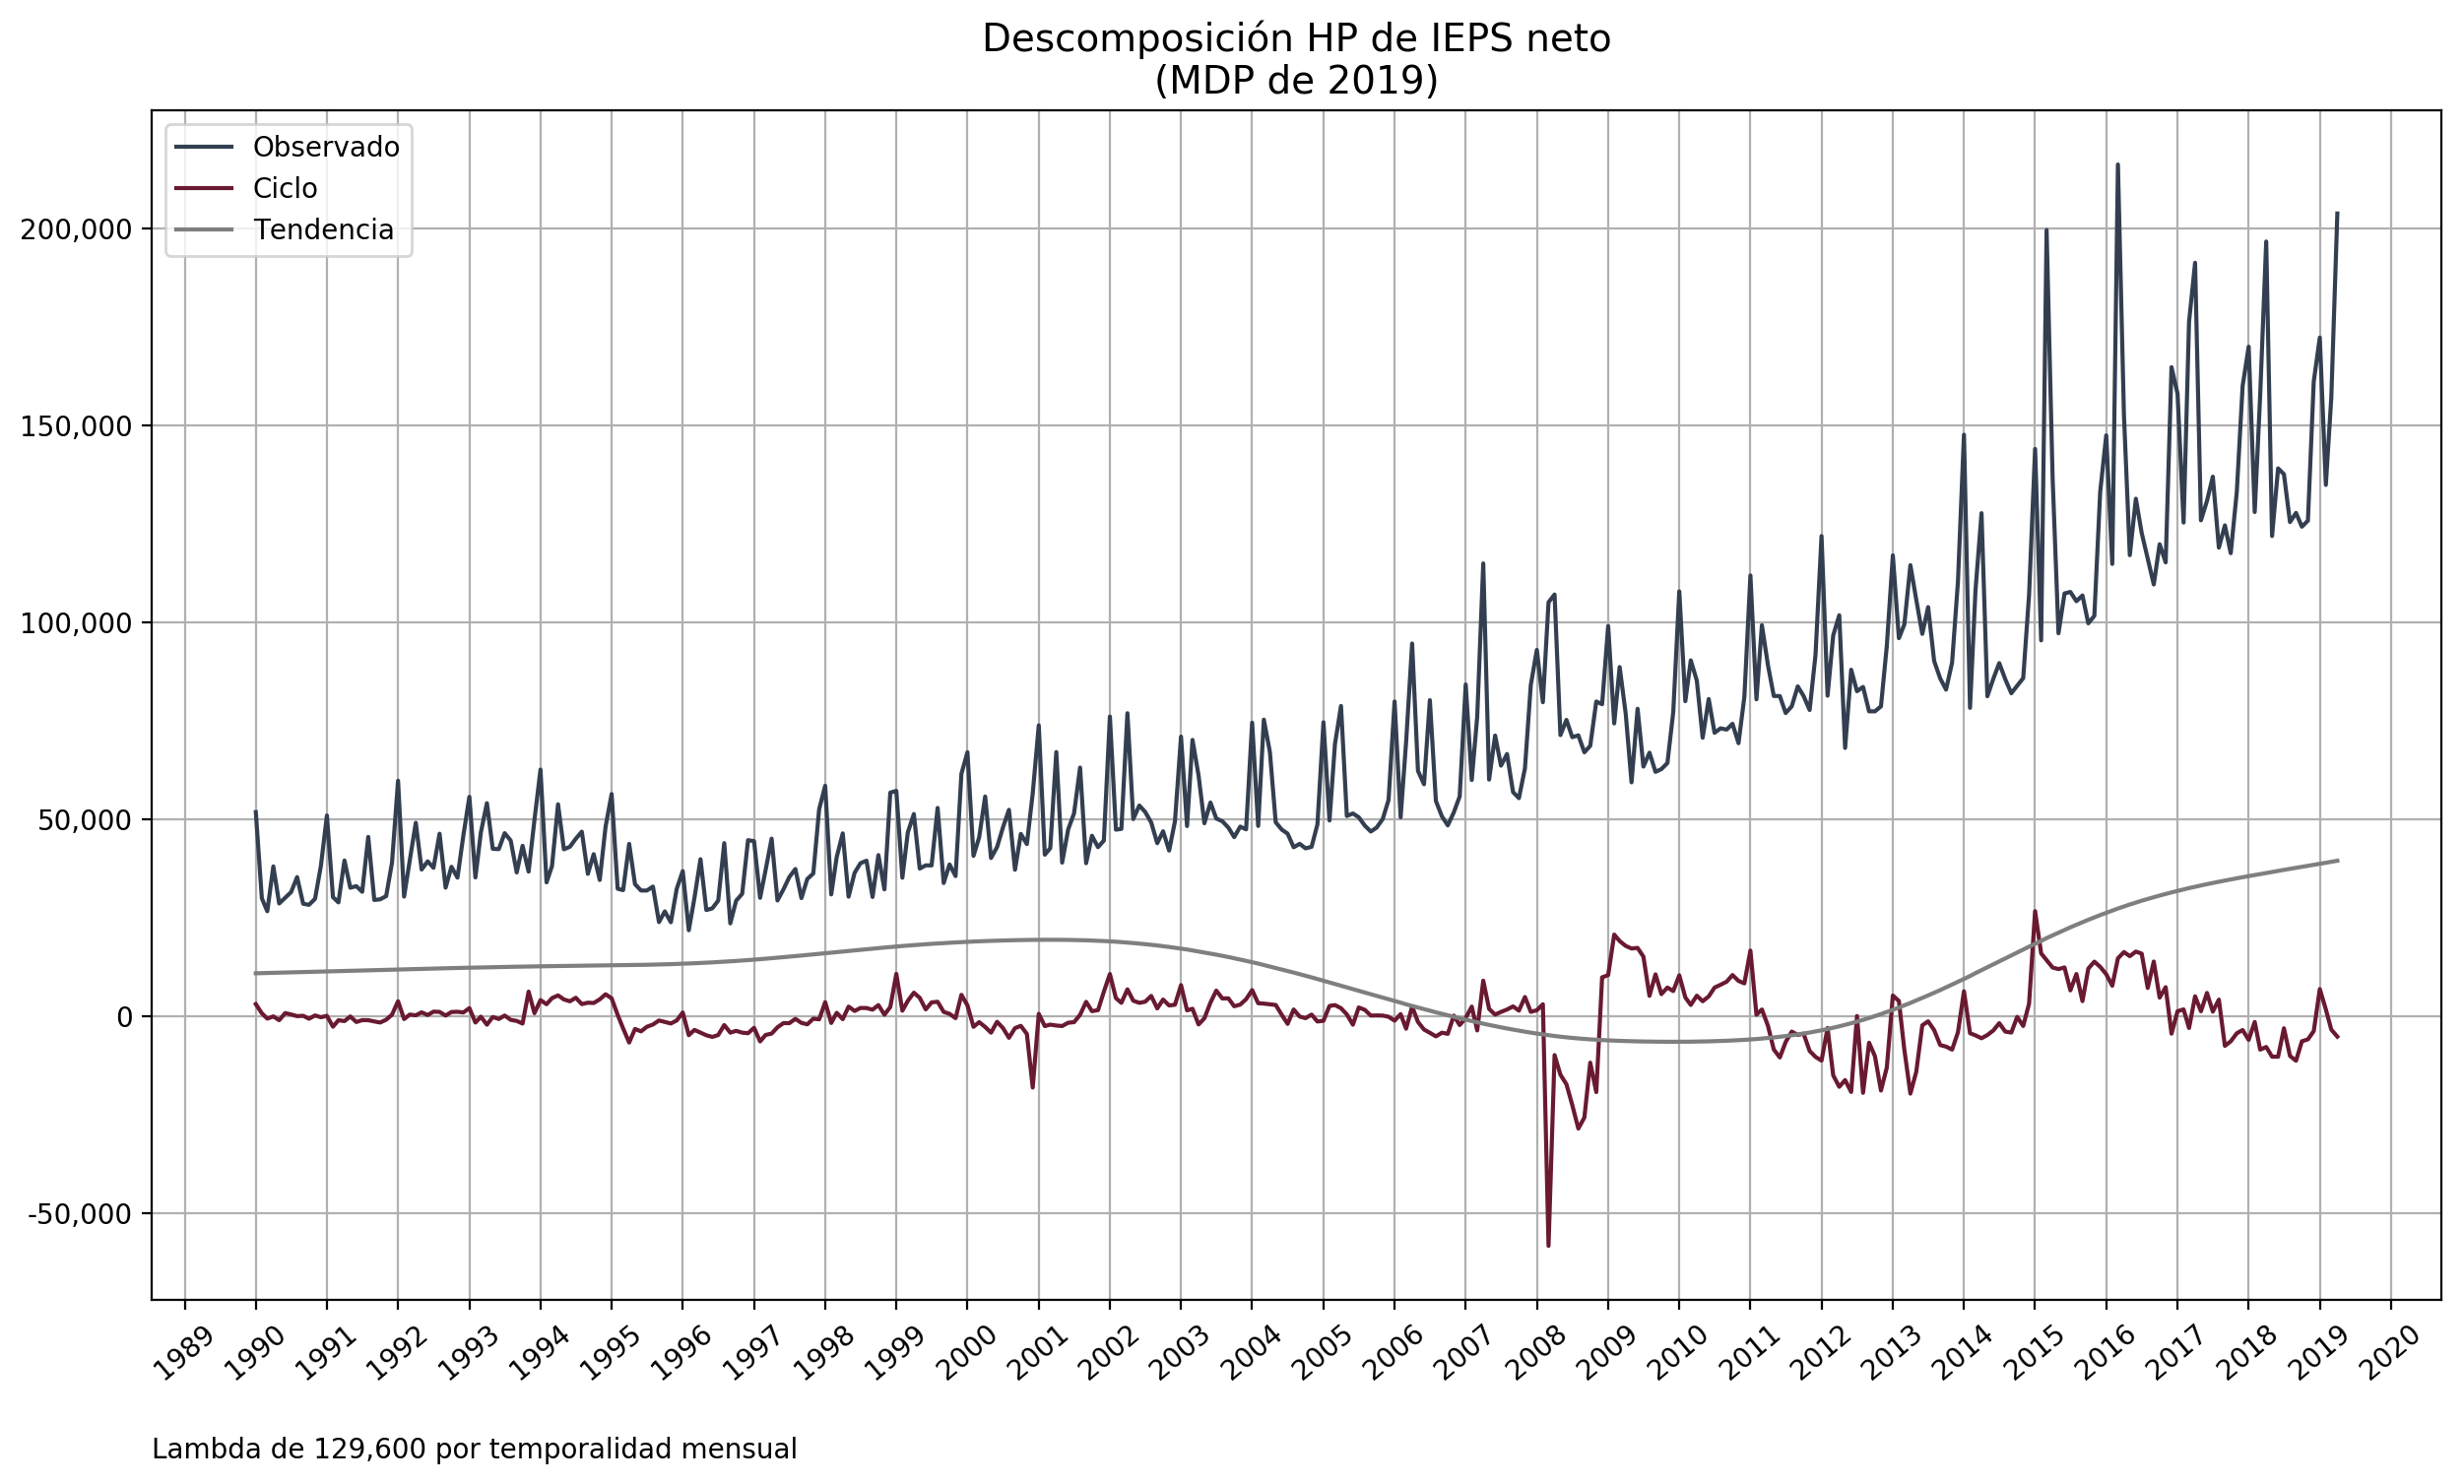

In [53]:
cycle_ieps, trend_ieps = sm.tsa.filters.hpfilter(fiscal_income_df['ieps_neto_(mdp)_r'], 129600)
hp_decomp_ieps = fiscal_income_df[['isr_neto_(mdp)_r']].copy()
hp_decomp_ieps["cycle"] = cycle_ieps
hp_decomp_ieps["trend"] = trend_ieps
descriptive.plot_series(hp_decomp_ieps,
                        title='Descomposición HP de {}'.format('IEPS neto'),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

In [36]:
fiscal_income_df['isr_neto_(mdp)_r']

fecha
1990-01-01     51743.806138
1990-02-01     29854.710181
1990-03-01     26566.336971
1990-04-01     37952.542920
1990-05-01     28550.338960
1990-06-01     30025.043879
1990-07-01     31427.283362
1990-08-01     35247.644959
1990-09-01     28468.401806
1990-10-01     28203.133548
1990-11-01     29718.262981
1990-12-01     38084.205400
1991-01-01     50880.188810
1991-02-01     30156.672487
1991-03-01     28815.961278
1991-04-01     39452.247299
1991-05-01     32537.884881
1991-06-01     32940.077322
1991-07-01     31508.967840
1991-08-01     45448.309255
1991-09-01     29438.785921
1991-10-01     29594.794294
1991-11-01     30415.258244
1991-12-01     38911.255554
1992-01-01     59703.245465
1992-02-01     30291.912421
1992-03-01     39460.199007
1992-04-01     49031.970817
1992-05-01     37157.758063
1992-06-01     39243.188850
1992-07-01     37604.268683
1992-08-01     46258.047185
1992-09-01     32562.263746
1992-10-01     37853.355102
1992-11-01     35097.987115
1992-12-01    

### Zoom a estacionalidad

In [ ]:
descriptive.plot_series(cycle, title='Ciclo de {}'.format(params['outcome_col']),
                        figsize=(15, 8), legend=False, ticks = 'monthly',
                        ticks_freq= 1, min_date= '2016-01-01')

## Testing for stationarity and transforming

In [ ]:
descriptive.test_stationarity(fiscal_income_df, params['outcome_col'])

In [ ]:
transforms = ['log', 'diff', 'log_diff']
for t in transforms:
    print('\n \n TRANSFORMATION {} \n'.format(t))
    new_serie_name = params['outcome_col'] + '_' + t
    fiscal_income_df[new_serie_name] = descriptive.transformation(fiscal_income_df, params['outcome_col'], t)
    descriptive.test_stationarity(fiscal_income_df, new_serie_name)

## Stationarity results
- level: Not stationary
- log: Not stationary
- diff: Stationary
- log_diff: Stationary

Vamos a usar log diff para el análisis